![MOSEK ApS](https://www.mosek.com/static/images/branding/webgraphmoseklogocolor.png )

We implement a Python Fusion model for the problem known as F-SPARC (fractional subcarrier and power allocation with rate constraints). Our implementation defines a mixed-integer exponential cone problem.

The model comes from the paper *Bi-Perspective Functions for Mixed-Integer Fractional Programs with Indicator Variables* by Adam N. Letchford, Qiang N and, Zhaoyu Zhong, http://www.optimization-online.org/DB_HTML/2017/09/6222.html.

Some test data come from http://www.research.lancs.ac.uk/portal/en/datasets/ofdma-optimisation(48d843b0-1fb6-4e3d-af39-ca533a37b7ab).html

# Problem formulation

We consider a set $I$ of communication channels (subcarriers) to be assigned to a set $J$ of users. Each channel can be assigned to at most one user, while one user will typically have more channels assigned to them, subject to the requirement that user $j$ achieves a total data rate of at least $d_j$ (bits per second). The data rate of a channel is computed as follows: for a channel of bandwidth $B$ (hertz), noise level $N_i$ (watts) and operating with power $p_i$ (watts), the maximum data rate is
$$f_i = B \log_2(1+\frac{p_i}{N_i}).$$
Finally, we assume a minimal system power of $\sigma$ required to keep the system running and a maximum power level $P$. 

The goal is to map the channels to users and assign their power levels so that the *energy efficiency*

$$\frac{\textrm{total data rate}}{\textrm{total power}}$$
is maximized.

The mixed-integer formulation is then:
$$
\begin{array}{rl}
\mathrm{maximize} & \frac{\sum_{i,j} B \log_2(1+p_{i,j}/N_i)}{\sigma+\sum_{i,j}p_{i,j}} \\
\textrm{subject to} & B \sum_i \log_2(1+p_{i,j}/N_i) \geq d_j, \quad j\in J, \\
& \sigma + \sum_{i,j}p_{ij} \leq P, \\
& 0 \leq p_{ij}\leq Px_{ij}, x_{ij}\in \{0,1\}, \\
& \sum_j x_{ij} \leq 1,\quad i\in I,
\end{array}
$$

where $p_{ij}$ is the power assigned to channel $i$ when used by user $j$. The first constraint describes the total bitrate of each user, the second bounds total power, and the remaining constraints with indicator variables model the assignment requirements.


# Conic reformulation

To obtain a problem in conic form we perform a homogenization as in Section 5.2 of Letchfort et al. That is, we introduce new variables $t$, $z_{ij}$ and $\tilde{p_{ij}}$ with the intention of representing
$$t = 1/(\sigma+\sum_{ij}p_{ij}),\quad z_{ij}=Bt\log_2(1+p_{ij}/N_i),\quad \tilde{p_{ij}} = p_{ij}t.$$
In terms of the new variables the problem is equivalent with

$$
\begin{array}{rl}
\mathrm{maximize} & \sum_{i,j} z_{ij} \\
\textrm{subject to} & z_{ij} \leq B t \log_2(1+\tilde{p_{i,j}}/(tN_i)), \quad i \in I, j\in J, \\
& d_jt \leq \sum_i z_{ij},\quad j\in J \\
& t\sigma + \sum_{i,j} \tilde{p_{i,j}} = 1, \\
& 1/P \leq t \leq 1/\sigma, \\
& 0 \leq \tilde{p_{i,j}} \leq x_{ij}, x_{ij}\in \{0,1\}, \\
& \sum_j x_{ij} \leq 1,\quad i\in I,
\end{array}
$$
The first constraint can equivalently be written as
$$t+\tilde{p_{i,j}}/N_i \geq t \exp(\log(2)z_{i,j}/(Bt))$$
which, using the exponential cone, is
$$(t+\tilde{p_{i,j}}/N_i , t, \log(2)z_{i,j}/B)\in K_\mathrm{exp}.$$

# Implementation in Fusion

We start that functions which parse examples in the format of http://www.research.lancs.ac.uk/portal/en/datasets/ofdma-optimisation(48d843b0-1fb6-4e3d-af39-ca533a37b7ab).html and set up some global constants. The data files contain user demands and channel noise for each example.

In [1]:
import ast, sys

constants = {
  "System Power": 10, 
  "Bandwidth": 1.25, 
  "Maximum Power": 36
}

def parse(filename):
    data = []
    with open(filename, 'r') as file:
        content = file.read()
        if 'Instance: ' not in content: raise Exception
            
        for inst in content.split('Instance: ')[1:]:
            if 'noise' not in inst or 'demand' not in inst: raise Exception

            data.append({
                "noise" : ast.literal_eval(inst.split('noise')[1].split('demand')[0].strip()), 
                "demand" : ast.literal_eval(inst.split('demand')[1].strip())
            })
    return data 

BW = constants["Bandwidth"]
P = constants["Maximum Power"]
SIGMA = constants["System Power"]

The next function is a direct implementation of the conic model above.

In [2]:
from mosek.fusion import *
from math import log

def fsparc_model(n, d):
    M = Model()
    I, J = len(n), len(d)

    # create variables
    z = M.variable('z', [I, J], Domain.greaterThan(0.0))            
    x = M.variable('x', [I, J], Domain.binary())                    
    p_tilde = M.variable('p_tilde', [I, J], Domain.greaterThan(0.0))
    t = M.variable('t', 1, Domain.inRange(1.0/P, 1.0/SIGMA))        

    # add linear constraints
    M.constraint(Expr.sum(x, 1), Domain.lessThan(1.0))              
    M.constraint(Expr.add(Expr.mul(SIGMA, t), Expr.sum(p_tilde)), Domain.equalsTo(1.0))
    M.constraint(Expr.sub(p_tilde, x), Domain.lessThan(0.0))                            
    M.constraint(Expr.sub(Expr.sum(z, 0), Expr.mulElm(Expr.repeat(t, J, 0), d)), Domain.greaterThan(0.0))
    
    # objective
    M.objective("obj", ObjectiveSense.Maximize, Expr.sum(z))
    
    # add conic constraint
    p_over_n = Expr.mulElm(p_tilde, [[1 / n_i] * J for n_i in n])
    multi_t = Expr.repeat(Expr.repeat(t, I, 0), J, 1)
    M.constraint(Expr.stack(2, Expr.add(multi_t, p_over_n), multi_t, Expr.mul(log(2.0) / BW, z)), 
                 Domain.inPExpCone())
    
    return M


Next we run the model and present some statistics for a few examples.

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

def stats(M, n, d):
    I, J = len(n), len(d)
    t    = M.getVariable('t').level()[0]
    pval = M.getVariable('p_tilde').level().reshape([I, J]) / t
    xval = M.getVariable('x').level().reshape([I, J])
    power = [sum(pval[i,:]) for i in range(I)]
    user = [int(sum([xval[i][j]*j for j in range(J)])) for i in range(I)]
    print("Total data rate: demanded {0}, provided {1}".format(
        sum(d), 
        sum([BW*log(1+power[i]/n[i])/log(2.0) for i in range(I)])))
    print("Power: system {0:.3f}, used {1:.3f}, maximal: {2:.3f}".format(SIGMA, SIGMA+sum(power), P))
    colors = ['red', 'green', 'blue', 'cyan', 'yellow', 'violet'] 
    plt.bar(range(I), power, color = [colors[user[i]] for i in range(I)])
    

# Example 1

We run an example with realistic data (72 channels, 4 users) with a very short time limit.

Problem
  Name                   :                 
  Objective sense        : max             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1229            
  Cones                  : 288             
  Scalar variables       : 1729            
  Matrix variables       : 0               
  Integer variables      : 288             

Optimizer started.
Mixed integer optimizer started.
Threads used: 20
Presolve started.
Presolve terminated. Time = 0.01
Presolved problem: 1440 variables, 940 constraints, 2883 non-zeros
Presolved problem: 0 general integer, 288 binary, 1152 continuous
Clique table size: 72
BRANCHES RELAXS   ACT_NDS  DEPTH    BEST_INT_OBJ         BEST_RELAX_OBJ       REL_GAP(%)  TIME  
0        1        1        0        NA                   3.2821073370e+02     NA          0.1   
Cut generation started.
0        2        1        0        NA                   3.2821073370e+02     NA          0.6   
Cut generation terminated. Time

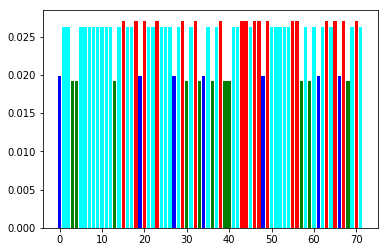

In [4]:
instance = parse("data/lancaster/4_0.8.txt")[0]
n, d = instance["noise"], instance["demand"]
M = fsparc_model(n, d)
M.setLogHandler(sys.stdout)
M.setSolverParam("optimizerMaxTime", 40.0)
M.solve()
M.acceptedSolutionStatus(AccSolutionStatus.Feasible)
stats(M, n, d)

The bar plot shows power assignments to the channels. Each color represents one user.

# Example 2

The next example is a small, randomly generated set of data with 15 channels and 3 users, which we should solve to optimality.

Problem
  Name                   :                 
  Objective sense        : max             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 199             
  Cones                  : 45              
  Scalar variables       : 271             
  Matrix variables       : 0               
  Integer variables      : 45              

Optimizer started.
Mixed integer optimizer started.
Threads used: 20
Presolve started.
Presolve terminated. Time = 0.00
Presolved problem: 225 variables, 153 constraints, 452 non-zeros
Presolved problem: 0 general integer, 45 binary, 180 continuous
Clique table size: 15
BRANCHES RELAXS   ACT_NDS  DEPTH    BEST_INT_OBJ         BEST_RELAX_OBJ       REL_GAP(%)  TIME  
0        1        1        0        NA                   6.2736906817e+01     NA          0.0   
Cut generation started.
0        2        1        0        NA                   6.2736906817e+01     NA          0.1   
Cut generation terminated. Time = 0

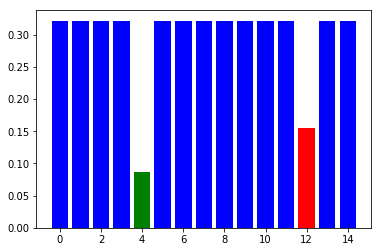

In [5]:
instance = parse("data/small-random/random_15_3_0.85.txt")[0]
n, d = instance["noise"], instance["demand"]
M = fsparc_model(n, d)
M.setLogHandler(sys.stdout)
M.solve()
stats(M, n, d)

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/80x15.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>. The **MOSEK** logo and name are trademarks of <a href="http://mosek.com">Mosek ApS</a>. The code is provided as-is. Compatibility with future release of **MOSEK** or the `Fusion API` are not guaranteed. For more information contact our [support](mailto:support@mosek.com). 